In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
import torch

class FloorSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return torch.floor(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through: just pass gradient through
        return grad_output

def ste_floor(x):
    return FloorSTE.apply(x)


class RoundSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through: just pass gradient through
        return grad_output

def ste_round(x):
    return RoundSTE.apply(x)

In [ ]:
# Test for ste_floor

x0 = torch.tensor([1.5, 2.6, 3.7], requires_grad=True)
const = torch.tensor([1., 2., 3.], requires_grad=False)
x1 = ste_floor(x0)

S = (x0 * const).sum()
S.backward()
x0.grad

tensor([1., 2., 3.])

In [ ]:
# Test for ste_round

x0 = torch.tensor([1.4, 2.6, 3.7], requires_grad=True)
const = torch.tensor([1., 2., 3.], requires_grad=False)
x1 = ste_round(x0)

S = (x0 * const).sum()
S.backward()
x0.grad

tensor([1., 2., 3.])

In [ ]:
import torch
from torch.ao.quantization.observer import MinMaxObserver
from torch import nn


class AffineQuantizerPerTensor(nn.Module):
    def __init__(self, bx=8):
        super().__init__()
        self.observer = MinMaxObserver(dtype=torch.quint8, qscheme=torch.per_tensor_affine, quant_min=0, quant_max=2**bx - 1)
        self.scale = None
        self.zero_point = None
        self.bx = bx
        self.enabled = True

    def enable(self):
        self.enabled = True

    def disable(self):
        self.enabled = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.enabled:
            self.observer(x)
            self.scale, self.zero_point = self.observer.calculate_qparams()

        if self.scale is None or self.zero_point is None:
            raise RuntimeError("Quantizer must be calibrated before use.")

        scale = self.scale.to(x.device)
        zero_point = self.zero_point.to(scale.dtype).to(x.device)

        xq = ste_round(x / scale + zero_point)
        xq = torch.clamp(xq, self.observer.quant_min, self.observer.quant_max)
        return xq


class SymmetricQuantizerPerTensor(nn.Module):
    def __init__(self, bw=8):
        super().__init__()
        maxval = 2 ** (bw - 1) - 1
        self.observer = MinMaxObserver(dtype=torch.quint8, qscheme=torch.per_tensor_symmetric, quant_min=-maxval, quant_max=maxval)
        self.scale = None
        self.bw = bw
        self.enabled = True

    def enable(self):
        self.enabled = True

    def disable(self):
        self.enabled = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.enabled:
            self.observer(x)
            self.scale, self.zero_point = self.observer.calculate_qparams()

        if self.scale is None or self.zero_point is None:
            raise RuntimeError("Quantizer must be calibrated before use.")

        scale = self.scale.to(x.device)

        xq = ste_round(x / scale)
        xq = torch.clamp(xq, self.observer.quant_min, self.observer.quant_max)
        return xq

class ADCQuantizer(nn.Module):
    def __init__(self, M, bx, bw, ba = 8, k = 4):
        super().__init__()
        self.delta = 2 * M * (2 ** bx - 1) * (2 ** (bw - 1) - 1) / ((2 ** ba - 1) * k)
        self.M = M
        self.bx = bx
        self.bw = bw
        self.ba = ba
        self.k = k

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xq = ste_floor(x / self.delta)
        mnval = -2 ** (self.ba - 1)
        mxval = 2 ** (self.ba - 1) - 1
        xq = torch.clamp(xq, mnval, mxval)
        return xq


In [ ]:
class LinearADC(nn.Linear):
    def __init__(self, in_features, out_features, bx=8, bw=8, ba=8, k=4, bias=True):
        super(LinearADC, self).__init__(in_features, out_features, bias)
        self.bx = bx
        self.bw = bw
        self.ba = ba
        self.x_quantizer = AffineQuantizerPerTensor(bx)
        self.w_quantizer = SymmetricQuantizerPerTensor(bw)
        self.adc_quantizer = ADCQuantizer(M=in_features, bx=bx, bw=bw, ba=ba, k=k)

    def dequantize(self, yq):

        # yq [B, O]

        # y = sum xq_i * wq_i
        # yq = y /

        y = yq * self.adc_quantizer.delta
        out = y - self.x_quantizer.zero_point / self.w_quantizer.scale * self.weight.sum(axis=-1)
        out = out * self.x_quantizer.scale * self.w_quantizer.scale
        return out

    def train(self, mode=True):
        super().train(mode)
        if (mode == True):
            self.x_quantizer.enable()
            self.w_quantizer.enable()
        else:
            self.x_quantizer.disable()
            self.w_quantizer.disable()
        return self

    def eval(self, mode=True):
        super().eval(mode)
        self.train(not mode)
        return self

    def forward(self, x):
        xq = self.x_quantizer(x)
        wq = self.w_quantizer(self.weight)
        y = nn.functional.linear(xq, wq)
        yq = self.adc_quantizer(y)
        out = self.dequantize(yq)
        if self.bias is not None:
            out = out + self.bias
        return out

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 256), # Input layer (28x28 images flattened)
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10) # Output layer (10 classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input images
        return self.layers(x)

In [ ]:
# Define the MLP model
class MLPADC(nn.Module):
    def __init__(self, bx=8, bw=8, ba=8, k=4,):
        super(MLPADC, self).__init__()
        self.layers = nn.Sequential(
            LinearADC(784, 256, bx, bw, ba, k), # Input layer (28x28 images flattened)
            nn.ReLU(),
            LinearADC(256, 128, bx, bw, ba, k),
            nn.ReLU(),
            LinearADC(128, 10, bx, bw, ba, k) # Output layer (10 classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input images
        return self.layers(x)

In [ ]:
from torchvision import datasets, transforms

# ... (rest of your code)

# Define a transform to normalize the data
transform_fm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)) # Normalize using mean and std dev of MNIST
])

# Download and load the training data
train_dataset_fm = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_fm)

# Download and load the test data
test_dataset_fm = datasets.FashionMNIST('./data', train=False, download=True, transform=transform_fm)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]


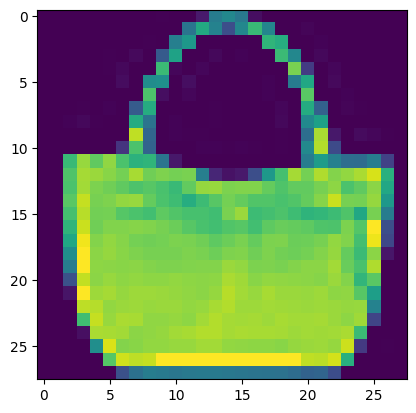

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(train_dataset_fm[100][0].reshape(28, 28))

In [ ]:
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset_fm, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_fm, batch_size=1000, shuffle=False)

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, optimizer, train_loader, test_loader, num_epochs=10):

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        loss_all = 0
        acc_all = 0
        for data, target in tqdm(train_loader, desc=f'Train epoch {epoch}/{num_epochs}'):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == target).float().sum()
            loss_all += loss.item()
            acc_all += acc
        loss_all /= len(train_loader.dataset)
        acc_all /= len(train_loader.dataset)
        print(f'Train Loss: {loss_all}, Train Acc: {acc_all}')
        train_losses.append(loss_all)
        train_accuracies.append(acc_all.cpu().item())

        model.eval()
        loss_all = 0
        acc_all = 0
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f'Test epoch {epoch}/{num_epochs}'):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                acc = (output.argmax(dim=1) == target).float().sum()
                loss_all += loss.item()
                acc_all += acc

            loss_all /= len(test_loader.dataset)
            acc_all /= len(test_loader.dataset)
            print(f'Test Loss: {loss_all}, Test Acc: {acc_all}')
            test_losses.append(loss_all)
            test_accuracies.append(acc_all.cpu().item())

    return train_losses, train_accuracies, test_losses, test_accuracies

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Eval'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            acc = (output.argmax(dim=1) == target).float().sum()
            correct += acc.cpu().item()
    test_loss /= len(test_loader.dataset)
    correct /= len(test_loader.dataset)
    return test_loss, correct



In [ ]:
def calibrate(model, test_loader):
    model.train()
    test_loss = 0
    correct = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Eval'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            acc = (output.argmax(dim=1) == target).float().sum()
            correct += acc.cpu().item()
    test_loss /= len(test_loader.dataset)
    correct /= len(test_loader.dataset)
    return test_loss, correct



In [ ]:
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, train_loader, test_loader, num_epochs=20)

Train epoch 0/20: 100%|██████████| 938/938 [00:13<00:00, 67.13it/s]


Train Loss: 0.00721277718146642, Train Acc: 0.8320666551589966


Test epoch 0/20: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Test Loss: 0.00041599195301532746, Test Acc: 0.8465999960899353


Train epoch 1/20: 100%|██████████| 938/938 [00:12<00:00, 72.57it/s]


Train Loss: 0.005356130203107993, Train Acc: 0.8736500144004822


Test epoch 1/20: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Test Loss: 0.0003602125495672226, Test Acc: 0.8669999837875366


Train epoch 2/20: 100%|██████████| 938/938 [00:12<00:00, 73.36it/s]


Train Loss: 0.004818547580639521, Train Acc: 0.8842833638191223


Test epoch 2/20: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Test Loss: 0.00035233524441719054, Test Acc: 0.8703999519348145


Train epoch 3/20: 100%|██████████| 938/938 [00:13<00:00, 71.73it/s]


Train Loss: 0.004394081575920184, Train Acc: 0.8950499892234802


Test epoch 3/20: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Test Loss: 0.000373055961728096, Test Acc: 0.8712999820709229


Train epoch 4/20: 100%|██████████| 938/938 [00:12<00:00, 73.25it/s]


Train Loss: 0.004178703177409868, Train Acc: 0.8996999859809875


Test epoch 4/20: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Test Loss: 0.0003508728176355362, Test Acc: 0.8738999962806702


Train epoch 5/20: 100%|██████████| 938/938 [00:12<00:00, 73.16it/s]


Train Loss: 0.0039040743250399828, Train Acc: 0.9045667052268982


Test epoch 5/20: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Test Loss: 0.00034309151768684387, Test Acc: 0.8836999535560608


Train epoch 6/20: 100%|██████████| 938/938 [00:12<00:00, 73.28it/s]


Train Loss: 0.0036493274522945286, Train Acc: 0.9113166928291321


Test epoch 6/20: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Test Loss: 0.0003455321252346039, Test Acc: 0.8818999528884888


Train epoch 7/20: 100%|██████████| 938/938 [00:13<00:00, 71.22it/s]


Train Loss: 0.003457586031034589, Train Acc: 0.9174667000770569


Test epoch 7/20: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Test Loss: 0.00032532451152801514, Test Acc: 0.8892999887466431


Train epoch 8/20: 100%|██████████| 938/938 [00:12<00:00, 73.34it/s]


Train Loss: 0.0032434034091730914, Train Acc: 0.9215999841690063


Test epoch 8/20: 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Test Loss: 0.0003380194574594498, Test Acc: 0.886199951171875


Train epoch 9/20: 100%|██████████| 938/938 [00:12<00:00, 72.92it/s]


Train Loss: 0.003083993276891609, Train Acc: 0.9245499968528748


Test epoch 9/20: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Test Loss: 0.00033875406086444855, Test Acc: 0.8849999904632568


Train epoch 10/20: 100%|██████████| 938/938 [00:13<00:00, 71.70it/s]


Train Loss: 0.002925878388931354, Train Acc: 0.9277499914169312


Test epoch 10/20: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Test Loss: 0.0003779812127351761, Test Acc: 0.8754000067710876


Train epoch 11/20: 100%|██████████| 938/938 [00:12<00:00, 72.24it/s]


Train Loss: 0.0027806766867016753, Train Acc: 0.9321500062942505


Test epoch 11/20: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Test Loss: 0.0003477201998233795, Test Acc: 0.8855999708175659


Train epoch 12/20: 100%|██████████| 938/938 [00:13<00:00, 69.48it/s]


Train Loss: 0.0026787519877776505, Train Acc: 0.9345833659172058


Test epoch 12/20: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Test Loss: 0.00035861955881118777, Test Acc: 0.8912000060081482


Train epoch 13/20: 100%|██████████| 938/938 [00:13<00:00, 71.67it/s]


Train Loss: 0.0025181936137688658, Train Acc: 0.9389833211898804


Test epoch 13/20: 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Test Loss: 0.0003616516947746277, Test Acc: 0.8940999507904053


Train epoch 14/20: 100%|██████████| 938/938 [00:12<00:00, 72.51it/s]


Train Loss: 0.002405961685317258, Train Acc: 0.9418166875839233


Test epoch 14/20: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Test Loss: 0.00038039774894714354, Test Acc: 0.8862999677658081


Train epoch 15/20: 100%|██████████| 938/938 [00:13<00:00, 71.63it/s]


Train Loss: 0.002286750077518324, Train Acc: 0.9444167017936707


Test epoch 15/20: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Test Loss: 0.00041974391639232637, Test Acc: 0.8844999670982361


Train epoch 16/20: 100%|██████████| 938/938 [00:13<00:00, 70.63it/s]


Train Loss: 0.0021562130969172964, Train Acc: 0.9471499919891357


Test epoch 16/20: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Test Loss: 0.0003901459455490112, Test Acc: 0.8898999691009521


Train epoch 17/20: 100%|██████████| 938/938 [00:12<00:00, 72.80it/s]


Train Loss: 0.0021295943628375728, Train Acc: 0.9474166631698608


Test epoch 17/20: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Test Loss: 0.00040855092108249666, Test Acc: 0.8908999562263489


Train epoch 18/20: 100%|██████████| 938/938 [00:12<00:00, 73.11it/s]


Train Loss: 0.0020575091113646826, Train Acc: 0.9500499963760376


Test epoch 18/20: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Test Loss: 0.0004302166432142258, Test Acc: 0.8854999542236328


Train epoch 19/20: 100%|██████████| 938/938 [00:12<00:00, 72.36it/s]


Train Loss: 0.0019548566044308244, Train Acc: 0.9523333311080933


Test epoch 19/20: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]

Test Loss: 0.0004729176491498947, Test Acc: 0.8910999894142151


In [ ]:
#torch.save(model.state_dict(), "model_gth.pt")
model = MLP().to(device)
model.load_state_dict(torch.load("model_gth.pt"))

<All keys matched successfully>

In [ ]:
model_adc8 = MLPADC(bx=8, bw=8, ba=8, k=4).to(device)
optimizer = torch.optim.Adam(model_adc8.parameters(), lr=0.001)
train_losses_adc8, train_accuracies_adc8, test_losses_adc8, test_accuracies_adc8 = train(model_adc8, optimizer, train_loader, test_loader, num_epochs=20)

Train epoch 0/20: 100%|██████████| 938/938 [00:17<00:00, 52.35it/s]


Train Loss: 0.007489740243305763, Train Acc: 0.822866678237915


Test epoch 0/20: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Test Loss: 0.0004649685949087143, Test Acc: 0.8126999735832214


Train epoch 1/20: 100%|██████████| 938/938 [00:18<00:00, 50.61it/s]


Train Loss: 0.0063196989949792625, Train Acc: 0.843666672706604


Test epoch 1/20: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Test Loss: 0.00044846313297748565, Test Acc: 0.840399980545044


Train epoch 2/20: 100%|██████████| 938/938 [00:18<00:00, 51.47it/s]


Train Loss: 0.006504509110748768, Train Acc: 0.840316653251648


Test epoch 2/20: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Test Loss: 0.000489807203412056, Test Acc: 0.8043999671936035


Train epoch 3/20: 100%|██████████| 938/938 [00:18<00:00, 51.84it/s]


Train Loss: 0.007220149974649151, Train Acc: 0.833299994468689


Test epoch 3/20: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Test Loss: 0.0005773833423852921, Test Acc: 0.838699996471405


Train epoch 4/20: 100%|██████████| 938/938 [00:18<00:00, 51.16it/s]


Train Loss: 0.00782016809756557, Train Acc: 0.8367833495140076


Test epoch 4/20: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Test Loss: 0.0007074754655361175, Test Acc: 0.8229999542236328


Train epoch 5/20: 100%|██████████| 938/938 [00:17<00:00, 52.58it/s]


Train Loss: 0.009090902652715643, Train Acc: 0.8377666473388672


Test epoch 5/20: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Test Loss: 0.000774140179157257, Test Acc: 0.8344999551773071


Train epoch 6/20: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s]


Train Loss: 0.011136348914727569, Train Acc: 0.8423333168029785


Test epoch 6/20: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Test Loss: 0.0008983431100845337, Test Acc: 0.8289999961853027


Train epoch 7/20: 100%|██████████| 938/938 [00:18<00:00, 51.25it/s]


Train Loss: 0.01183038212954998, Train Acc: 0.8483666777610779


Test epoch 7/20: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


Test Loss: 0.0010662906408309936, Test Acc: 0.8082000017166138


Train epoch 8/20: 100%|██████████| 938/938 [00:17<00:00, 53.10it/s]


Train Loss: 0.013582917484268545, Train Acc: 0.850350022315979


Test epoch 8/20: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Test Loss: 0.0012021382331848145, Test Acc: 0.8317999839782715


Train epoch 9/20: 100%|██████████| 938/938 [00:17<00:00, 52.16it/s]


Train Loss: 0.015703000795096157, Train Acc: 0.8551999926567078


Test epoch 9/20: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Test Loss: 0.0014889022946357727, Test Acc: 0.824400007724762


Train epoch 10/20: 100%|██████████| 938/938 [00:18<00:00, 51.10it/s]


Train Loss: 0.016546212731301784, Train Acc: 0.8551833629608154


Test epoch 10/20: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Test Loss: 0.0018572172284126282, Test Acc: 0.8324999809265137


Train epoch 11/20: 100%|██████████| 938/938 [00:17<00:00, 52.80it/s]


Train Loss: 0.018942574762056272, Train Acc: 0.8585500121116638


Test epoch 11/20: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Test Loss: 0.0018251892447471618, Test Acc: 0.8398000001907349


Train epoch 12/20: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]


Train Loss: 0.021602123663201928, Train Acc: 0.8627166748046875


Test epoch 12/20: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Test Loss: 0.0021529173612594606, Test Acc: 0.8411999940872192


Train epoch 13/20: 100%|██████████| 938/938 [00:18<00:00, 50.16it/s]


Train Loss: 0.027502763337021074, Train Acc: 0.8606333136558533


Test epoch 13/20: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Test Loss: 0.0029578522682189943, Test Acc: 0.8393999934196472


Train epoch 14/20: 100%|██████████| 938/938 [00:18<00:00, 51.67it/s]


Train Loss: 0.03297291493515173, Train Acc: 0.8601833581924438


Test epoch 14/20: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


Test Loss: 0.0038119203329086302, Test Acc: 0.8269000053405762


Train epoch 15/20: 100%|██████████| 938/938 [00:18<00:00, 50.60it/s]


Train Loss: 0.0381924197102276, Train Acc: 0.8627333641052246


Test epoch 15/20: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Test Loss: 0.004110025930404663, Test Acc: 0.842199981212616


Train epoch 16/20: 100%|██████████| 938/938 [00:18<00:00, 49.79it/s]


Train Loss: 0.04171617711248497, Train Acc: 0.8666999936103821


Test epoch 16/20: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Test Loss: 0.004417714691162109, Test Acc: 0.8362999558448792


Train epoch 17/20: 100%|██████████| 938/938 [00:18<00:00, 51.95it/s]


Train Loss: 0.04320026886627699, Train Acc: 0.8701333403587341


Test epoch 17/20: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


Test Loss: 0.004695555591583252, Test Acc: 0.8456999659538269


Train epoch 18/20: 100%|██████████| 938/938 [00:18<00:00, 50.26it/s]


Train Loss: 0.049469819265728195, Train Acc: 0.8689666986465454


Test epoch 18/20: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Test Loss: 0.0054619251728057865, Test Acc: 0.8445999622344971


Train epoch 19/20: 100%|██████████| 938/938 [00:18<00:00, 50.06it/s]


Train Loss: 0.054020337089151146, Train Acc: 0.8718667030334473


Test epoch 19/20: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s]

Test Loss: 0.006594453859329223, Test Acc: 0.849399983882904


In [ ]:
torch.save(model_adc8.state_dict(), "adc8.pt")

In [ ]:
model_adc4 = MLPADC(bx=4, bw=4, ba=8, k=4).to(device)
optimizer = torch.optim.Adam(model_adc4.parameters(), lr=0.001)
train_losses_adc4, train_accuracies_adc4, test_losses_adc4, test_accuracies_adc4 = train(model_adc4, optimizer, train_loader, test_loader, num_epochs=20)

Train epoch 0/20: 100%|██████████| 938/938 [00:18<00:00, 51.99it/s]


Train Loss: 0.007622110737115145, Train Acc: 0.8204166889190674


Test epoch 0/20: 100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Test Loss: 0.0004585301071405411, Test Acc: 0.8428999781608582


Train epoch 1/20: 100%|██████████| 938/938 [00:18<00:00, 50.18it/s]


Train Loss: 0.006271398983026544, Train Acc: 0.8477666974067688


Test epoch 1/20: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Test Loss: 0.00043459791243076327, Test Acc: 0.8472999930381775


Train epoch 2/20: 100%|██████████| 938/938 [00:18<00:00, 50.11it/s]


Train Loss: 0.006542373714099328, Train Acc: 0.8380833268165588


Test epoch 2/20: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Test Loss: 0.0005207761734724044, Test Acc: 0.8220999836921692


Train epoch 3/20: 100%|██████████| 938/938 [00:18<00:00, 51.94it/s]


Train Loss: 0.007224289211506645, Train Acc: 0.8353333473205566


Test epoch 3/20: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Test Loss: 0.0006034641444683075, Test Acc: 0.8297999501228333


Train epoch 4/20: 100%|██████████| 938/938 [00:18<00:00, 50.33it/s]


Train Loss: 0.007940928692494829, Train Acc: 0.8328333497047424


Test epoch 4/20: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Test Loss: 0.0006812879383563996, Test Acc: 0.81659996509552


Train epoch 5/20: 100%|██████████| 938/938 [00:18<00:00, 49.98it/s]


Train Loss: 0.00874483356649677, Train Acc: 0.8420166969299316


Test epoch 5/20: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Test Loss: 0.0007425889432430267, Test Acc: 0.8435999751091003


Train epoch 6/20: 100%|██████████| 938/938 [00:18<00:00, 51.93it/s]


Train Loss: 0.009753611830001075, Train Acc: 0.8435333371162415


Test epoch 6/20: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Test Loss: 0.0007822425603866577, Test Acc: 0.8416000008583069


Train epoch 7/20: 100%|██████████| 938/938 [00:18<00:00, 50.75it/s]


Train Loss: 0.0107813435194393, Train Acc: 0.8458499908447266


Test epoch 7/20: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Test Loss: 0.000942927235364914, Test Acc: 0.820099949836731


Train epoch 8/20: 100%|██████████| 938/938 [00:18<00:00, 50.12it/s]


Train Loss: 0.01227231551433603, Train Acc: 0.8504666686058044


Test epoch 8/20: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Test Loss: 0.0010862877070903778, Test Acc: 0.8073999881744385


Train epoch 9/20: 100%|██████████| 938/938 [00:18<00:00, 51.60it/s]


Train Loss: 0.013055962414170305, Train Acc: 0.854033350944519


Test epoch 9/20: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Test Loss: 0.0011788336157798767, Test Acc: 0.8416999578475952


Train epoch 10/20: 100%|██████████| 938/938 [00:18<00:00, 50.60it/s]


Train Loss: 0.014835804576737185, Train Acc: 0.8565166592597961


Test epoch 10/20: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Test Loss: 0.0012714954137802124, Test Acc: 0.8300999999046326


Train epoch 11/20: 100%|██████████| 938/938 [00:18<00:00, 50.01it/s]


Train Loss: 0.01699825804034869, Train Acc: 0.8547166585922241


Test epoch 11/20: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Test Loss: 0.0015599650502204894, Test Acc: 0.8226000070571899


Train epoch 12/20: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s]


Train Loss: 0.017966102833487093, Train Acc: 0.8570833206176758


Test epoch 12/20: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Test Loss: 0.0020562365889549255, Test Acc: 0.8269000053405762


Train epoch 13/20: 100%|██████████| 938/938 [00:18<00:00, 50.75it/s]


Train Loss: 0.024477806384551028, Train Acc: 0.8552666902542114


Test epoch 13/20: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Test Loss: 0.0027457602739334105, Test Acc: 0.8391000032424927


Train epoch 14/20: 100%|██████████| 938/938 [00:18<00:00, 49.39it/s]


Train Loss: 0.029365170386930307, Train Acc: 0.8601500391960144


Test epoch 14/20: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Test Loss: 0.0036284214735031128, Test Acc: 0.8520999550819397


Train epoch 15/20: 100%|██████████| 938/938 [00:18<00:00, 51.49it/s]


Train Loss: 0.03251109852132698, Train Acc: 0.8604166507720947


Test epoch 15/20: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


Test Loss: 0.003459614896774292, Test Acc: 0.8355000019073486


Train epoch 16/20: 100%|██████████| 938/938 [00:18<00:00, 51.41it/s]


Train Loss: 0.04622501011441151, Train Acc: 0.8611166477203369


Test epoch 16/20: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Test Loss: 0.0053990968704223635, Test Acc: 0.840999960899353


Train epoch 17/20: 100%|██████████| 938/938 [00:19<00:00, 48.97it/s]


Train Loss: 0.05238252695885797, Train Acc: 0.8651666641235352


Test epoch 17/20: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Test Loss: 0.0062779998779296875, Test Acc: 0.8373000025749207


Train epoch 18/20: 100%|██████████| 938/938 [00:18<00:00, 49.97it/s]


Train Loss: 0.06258927761117618, Train Acc: 0.8661333322525024


Test epoch 18/20: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Test Loss: 0.006115335321426392, Test Acc: 0.8411999940872192


Train epoch 19/20: 100%|██████████| 938/938 [00:18<00:00, 51.63it/s]


Train Loss: 0.06858760107395549, Train Acc: 0.8654500246047974


Test epoch 19/20: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]

Test Loss: 0.007676176929473877, Test Acc: 0.8411999940872192


In [ ]:
torch.save(model_adc4.state_dict(), "adc4.pt")

In [ ]:
def get_metrics(target, donor, train_loader, test_loader):
    target.load_state_dict(donor.state_dict(), strict=False)
    _, train_acc = evaluate(target, train_loader)
    _, test_acc = evaluate(target, test_loader)
    return train_acc, test_acc

### Running the trained models with their own weights

In [ ]:
evaluate(model, test_loader)

Eval: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


(0.0004729176491498947, 0.8911)

In [ ]:
evaluate(model_adc4, test_loader)

Eval: 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


(0.007676176929473877, 0.8412)

In [ ]:
evaluate(model_adc8, test_loader)

Eval: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


(0.006594453859329223, 0.8494)

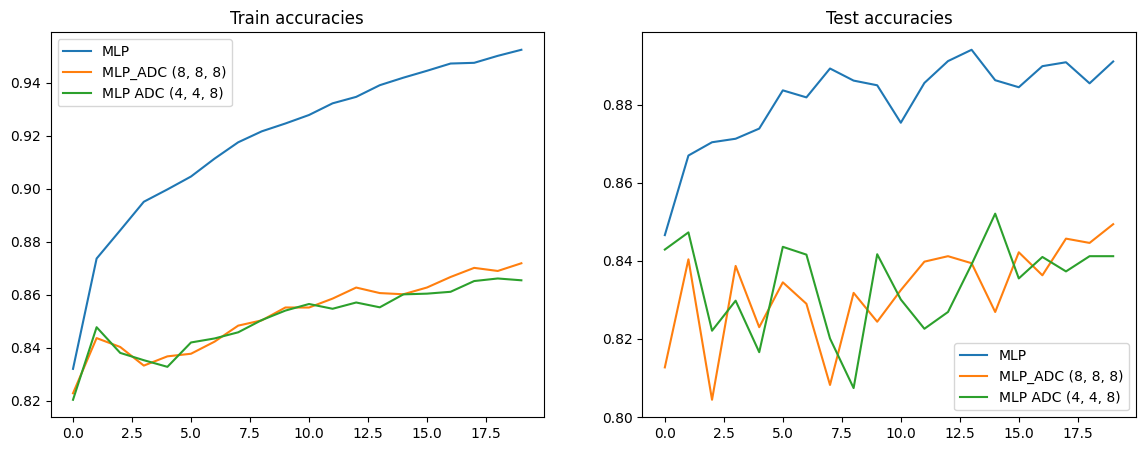

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(train_accuracies, label='MLP')
ax[0].plot(train_accuracies_adc8, label='MLP_ADC (8, 8, 8)')
ax[0].plot(train_accuracies_adc4, label='MLP ADC (4, 4, 8)')
ax[0].set_title("Train accuracies")
ax[0].legend()

ax[1].plot(test_accuracies, label='MLP')
ax[1].plot(test_accuracies_adc8, label='MLP_ADC (8, 8, 8)')
ax[1].plot(test_accuracies_adc4, label='MLP ADC (4, 4, 8)')
ax[1].set_title("Test accuracies")
ax[1].legend()
plt.show()

### Load weights from usual model to quantized models

In [ ]:
model_adc4_copy = MLPADC(bx=4, bw=4, ba=8, k=4).to(device)
model_adc4_copy.load_state_dict(torch.load("model_gth.pt"), strict=False)
calibrate(model_adc4_copy, train_loader)
evaluate(model_adc4_copy, test_loader)

Eval: 100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


(0.002119978976249695, 0.1279)

In [ ]:
model_adc8_copy = MLPADC(bx=8, bw=8, ba=8, k=4).to(device)
model_adc8_copy.load_state_dict(torch.load("model_gth.pt"), strict=False)
calibrate(model_adc8_copy, train_loader)
evaluate(model_adc8_copy, test_loader)

Eval: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


(0.002236054754257202, 0.3552)

### Copy weights from quantized model to usual model

In [ ]:
model_copy8 = MLP().to(device)

print("Model with weights from ADC8 (Train/Test):",  get_metrics(model_copy8, model_adc8, train_loader, test_loader))

model_copy4 = MLP().to(device)

print("Model with weights from ADC4 (Train/Test):",  get_metrics(model_copy4, model_adc4, train_loader, test_loader))

Eval: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Model with weights from ADC8 (Train/Test): (0.8688833333333333, 0.8408)


Eval: 100%|██████████| 10/10 [00:01<00:00,  5.45it/s]

Model with weights from ADC4 (Train/Test): (0.8779333333333333, 0.8527)


In [ ]:
f_w = open("logs_adc_train_fm.txt", "w")
f_w.write("Train accuracies (Normal, ADC8, ADC4)\n")
for arr in [train_accuracies, train_accuracies_adc8, train_accuracies_adc4]:
    f_w.write(' '.join(map(str, arr)) + '\n\n')
f_w.write("Test accuracies (Normal, ADC8, ADC4)\n")
for arr in [test_accuracies, test_accuracies_adc8, test_accuracies_adc4]:
    f_w.write(' '.join(map(str, arr)) + '\n\n')
f_w.close()

In [ ]:
xq = quant(x)
wq = quant(w)
yq = adc(xq * wq)
y = dequant(y) # * sx * sw


x2 = dequant(quant(x)) # *sx
w2 = dequant(quant(w)) # *sw

y = x2 * w2

In [ ]:
layer1 = LinearADC(in_features=10, out_features=20, bx=4, bw=4, ba=8, k=4, bias=True)
layer2 = nn.Linear(in_features=10, out_features=20, bias=True)

layer2.weight.data = layer1.weight.data
layer2.bias.data = layer1.bias.data
#layer2.bias.data = layer1.bias.data

layer3 = nn.Linear(in_features=10, out_features=20, bias=True)

In [ ]:
x0 = torch.rand((25, 10)) * 50 + 25

x1 = layer1(x0)
x2 = layer2(x0)
x3 = layer3(x0)

print((x1 - x2).abs().max())
print((x1 - x3).abs().max())

tensor(20.3340, grad_fn=<MaxBackward1>)
tensor(93.3881, grad_fn=<MaxBackward1>)


In [ ]:
layer1 = LinearADC(in_features=10, out_features=10, bx=4, bw=4, ba=8, k=4, bias=False)

layer1.weight.data = torch.eye(10)

In [ ]:
x0

tensor([[26.7304, 31.1513, 73.0270, 73.2582, 25.4829, 57.6110, 71.7957, 56.5365,
         48.0360, 61.3831],
        [71.1674, 62.0212, 65.4115, 67.3896, 59.8313, 39.2201, 26.5138, 58.9137,
         27.4972, 37.4439],
        [64.1427, 50.1639, 67.6197, 37.8770, 69.8616, 63.2886, 62.4166, 49.6351,
         53.1945, 61.1669],
        [67.9047, 42.8480, 71.8593, 63.6100, 69.7647, 40.8776, 56.3050, 67.1926,
         68.6809, 32.7199],
        [70.0239, 36.6163, 49.4229, 66.0521, 41.1920, 34.8372, 27.0024, 47.9584,
         50.1099, 70.9660],
        [32.4002, 44.0996, 62.7994, 41.6385, 50.3549, 74.5170, 54.6598, 67.6990,
         58.5949, 55.0868],
        [60.5230, 70.6212, 46.8392, 59.7478, 71.5800, 70.5334, 71.2752, 63.2632,
         54.3709, 35.4932],
        [39.8587, 67.6553, 61.6394, 71.9415, 57.2732, 62.6702, 46.9879, 62.8128,
         71.4001, 74.1147],
        [72.2134, 47.5278, 71.6986, 55.3964, 29.9752, 54.4356, 65.0204, 27.3818,
         34.1485, 71.3202],
        [34.2029, 3

In [ ]:
layer1(x0) - x0

tensor([[ -6.2748,  -6.3123, -14.5822, -14.8135,  -5.0273, -10.8552, -13.3510,
          -9.7807, -10.0470, -11.7051],
        [-12.7227, -12.3431, -11.3501, -13.3282, -10.1533,  -9.9978,  -6.0581,
         -12.1579,  -7.0416,  -8.2215],
        [-14.4647,  -7.7914, -13.5583,  -8.6546, -11.4169, -13.6106, -12.7386,
         -11.6460, -10.8220, -11.4888],
        [-13.8433,  -9.2423, -13.4146, -13.9320, -11.3200,  -7.2718,  -9.5492,
         -13.1312, -14.6195,  -7.8809],
        [-11.5792,  -7.3940, -11.4339, -11.9907,  -7.5863,  -5.6149,  -6.5468,
          -9.9693,  -7.7375, -12.5213],
        [ -7.5612, -10.4938, -13.1214,  -8.0328,  -7.9825, -11.6889,  -7.9040,
         -13.6376, -11.8391,  -8.3310],
        [-10.8450, -12.1764,  -8.8501, -10.0698, -13.1353, -12.0886, -12.8305,
         -13.5851, -11.9985,  -6.2708],
        [ -6.2530, -13.5939, -11.9614, -13.4968, -10.5174, -12.9921,  -8.9988,
         -13.1348, -12.9554, -15.6699],
        [-13.7686,  -9.5387, -13.2539,  -8.6406,